In [1]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
###############################################################################
####################### EVALUATE SPINUP FOR LES DOMAINS #######################
###############################################################################

#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as mpyplot
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              


print("done importing modules")


done importing modules


In [5]:
#%% Define file locations
WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/nudge_sst_32/"  
# WRF_DIRECTORY = "/pl/active/WRFLES_GAD/hurricanes/sst_26/"  

# Choose which domain to evaluate
domain = 'd04'

# Whether or not to save figures
saveFig = 'False'

# Decide whether or not to save 1-min wind speed
saveCat = 'False'

# Decide whether or not to interpolate to z=10m
interp_to10 = 'False'

# Time series output for each restart
if 'sst_26' in WRF_DIRECTORY:
    restarts = ['timeSeries_08-00__08-05','timeSeries_08-05__08-06_newLocs']
elif 'sst_28' in WRF_DIRECTORY:
    restarts = ['timeSeries_07-00_07-05','timeSeries_07-05__07-06_newLocs'] #_newLocs
elif 'sst_30' in WRF_DIRECTORY:
    restarts = ['timeSeries_07-07__07-11','timeSeries_07-11__07-12']
elif 'sst_32' in WRF_DIRECTORY:
    restarts = ['timeSeries_07-00_07-05','timeSeries_07-04_07-05']
    
if domain=='d05':
    restarts = restarts[1]
elif domain=='d04':
    restarts = restarts[0]

# Start time for simulations
startTime = np.datetime64('2000-01-01T00:00:00')

# Subsample data to reduce computational time and memory requirements
ss = 1


In [6]:
#%% Extract data for domain size
# Find auxHist files for current domain
entries = os.listdir(WRF_DIRECTORY)
ofInterest = []
for i in np.arange(len(entries)):
    if domain in entries[i]:
        if 'auxH' in entries[i]:
            ofInterest = np.append(ofInterest,i)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)
print(entries[rndmFromInterest])

# Extract data from auxHist file
ds = xr.open_dataset(WRF_DIRECTORY+str(entries[rndmFromInterest]),decode_times=False)
u = ds['U']
u = np.array(u[0,:,:,:])
v = ds['V']
v = np.array(v[0,:,:,:])
# De-stagger wind speed
u_des = 0.5*(u[:,:,0:np.shape(u)[2]-1]+u[:,:,1:np.shape(u)[2]])
u = 0.0
v_des = 0.5*(v[:,0:np.shape(v)[1]-1,:]+v[:,1:np.shape(v)[1],:])
v = 0.0
# horizontal wind speed
uv = np.sqrt(np.array(u_des)**2 + np.array(v_des)**2)
u_des = 0.0
v_des = 0.0
# Domain dimensions
dx = ds.DX
n_x = dx*np.arange(0,np.shape(uv)[2])
n_y = dx*np.arange(0,np.shape(uv)[1])
ds.close()


auxHist24_d04_2000-01-07_00:30:41


In [7]:
# Time series locations
# Station locations
locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist_d04_d05.txt',skiprows=3,usecols=(2,3)) # [i,j]
name_locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist_d04_d05.txt',skiprows=3,usecols=(1),dtype='U')

# Turbine specifications
D = 126
z_hh = 90
rated_ws = 11.4

print("Done extracting data from general variables")


Done extracting data from general variables


In [8]:
#%% Define use for each station
# Define number of "stations" for high-temporal resolution data 
if domain=='d05':
    which_stations = 'hi'
elif domain=='d04':
    which_stations = 'lol'

# Remove time series locations that are not going to be used in analysis
stations = []
for i in np.arange(len(name_locs)):
    if which_stations in name_locs[i]:
        stations = np.append(stations,i)
stations = stations.astype('int')
# stations = stations[:9]
# stations = stations[::9]
# stations = stations[18:63:2]
# stations = stations[85:100]
# stations = stations[18:11*9]
print(stations)
locs = locs[stations]
name_locs = name_locs[stations]
print(name_locs)

# Remove time series locations that are incorrect
if domain=='d05':
    stats = []
    for i in np.arange(len(name_locs)):
        if not locs[i,0] == locs[i,1]:
            stats = np.append(stats,i)       
    stats = stats.astype('int')
    print(stats)
    locs = locs[stats]
    name_locs = name_locs[stats]
    print(name_locs)

locs = locs.astype('int')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
['lol00' 'lol01' 'lol02' 'lol03' 'lol04' 'lol05' 'lol06' 'lol07' 'lol08'
 'lol09' 'lol10' 'lol11' 'lol12' 'lol13' 'lol14' 'lol15' 'lol16' 'lol17'
 'lol18' 'lol19' 'lol20' 'lol21' 'lol22' 'lol23' 'lol24' 'lol25' 'lol26']


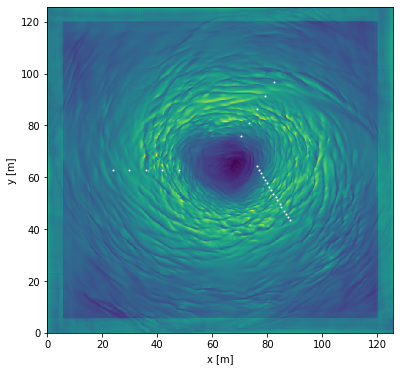

In [9]:
#%% Show relative locations of met tower in the domain
mpyplot.figure(figsize=(6.2,6))
mpyplot.pcolormesh(n_x/1000,n_y/1000,uv[0,:,:])
mpyplot.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=1,color='white')
# mpyplot.scatter(n_x[locs[19,0]]/1000,n_y[locs[19,1]]/1000,s=1,color='red')
# mpyplot.scatter(n_x[locs[26,0]]/1000,n_y[locs[26,1]]/1000,s=1,color='red')
mpyplot.xlabel('x [m]')
mpyplot.ylabel('y [m]')
mpyplot.show()

In [7]:
#%% Extract high-temporal resolution data
# Time arrays
temp = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[-1]+'.'+domain+'.UU',skiprows=1)
init_temp = temp[:,0]
time = temp[::ss,0]*(3600/1) # seconds since start of simulation
time_sinceRst = time - time[0] # seconds since initialization
TIME = startTime + time.astype('timedelta64[s]')

# Height array
GHT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[0]+'.'+domain+'.PH',skiprows=1)
hgt_agl_stg = GHT[::ss,1:] - GHT[0,1]
hgt_agl_stg = np.mean(hgt_agl_stg,axis=0)
hgt_agl = 0.5*(hgt_agl_stg[1:] + hgt_agl_stg[0:-1])
hgt_agl = np.append(hgt_agl,hgt_agl[-1] + (hgt_agl[-1] - hgt_agl[-2]))

# Initialize arrays [station,valForEachTimeStep,height]
U = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
V = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
W = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
# theta = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])

# Extract data for each station
for i_s in np.arange(0,len(locs)):
    # Load data
    tempU = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.UU',skiprows=1)
    tempV = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.VV',skiprows=1)
    tempW = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.WW',skiprows=1)
#     tempT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.TH',skiprows=1)
    # Save data
    U[i_s,:,:] = tempU[:np.shape(init_temp)[0]:ss,1:]
    V[i_s,:,:] = tempV[:np.shape(init_temp)[0]:ss,1:]
    W[i_s,:,:] = tempW[:np.shape(init_temp)[0]:ss,1:]
#     theta[i_s,:,:] = tempT[:np.shape(init_temp)[0]:ss,1:]

    print('Done with %i out of %i' % (i_s,len(locs)-1))


# Calculate horizontal wind speed
UV = np.sqrt(U**2 + V**2)

print("Done extracting high-temporal resolution data")


Done with 0 out of 26
Done with 1 out of 26
Done with 2 out of 26
Done with 3 out of 26
Done with 4 out of 26
Done with 5 out of 26
Done with 6 out of 26
Done with 7 out of 26
Done with 8 out of 26
Done with 9 out of 26
Done with 10 out of 26
Done with 11 out of 26
Done with 12 out of 26
Done with 13 out of 26
Done with 14 out of 26
Done with 15 out of 26
Done with 16 out of 26
Done with 17 out of 26
Done with 18 out of 26
Done with 19 out of 26
Done with 20 out of 26
Done with 21 out of 26
Done with 22 out of 26
Done with 23 out of 26
Done with 24 out of 26
Done with 25 out of 26
Done with 26 out of 26
Done extracting high-temporal resolution data


In [8]:
#%% Calculate wind direction using time series output
wDir = np.zeros(np.shape(U))

for i_s in np.arange(np.shape(locs)[0]):
    for iz in np.arange(len(hgt_agl)):
        uu = np.zeros_like(U[i_s,:,iz]) + U[i_s,:,iz]
        vv = np.zeros_like(V[i_s,:,iz]) + V[i_s,:,iz]
#         vv[vv==0] = 0.1
#         wDir[i_s,:,iz] = np.arctan(uu/vv)*180/np.pi
        wDir[i_s,:,iz] = np.arctan2(vv,uu)*180/np.pi
        
uu = 0
vv = 0

# Wind direction in engineering coordinates (from [1,0] vector )
wDir[wDir<0] = (180 + wDir[wDir<0]) + 180


In [9]:
#%% Interpolate lowest heights to 10 m

if interp_to10=='True':
    zz = 10
    i_z_stg = np.argmin(np.abs(hgt_agl_stg - zz))

    U[:,:,0] = U[:,:,0] + (U[:,:,1] - U[:,:,0])*(zz - hgt_agl_stg[0])/(hgt_agl_stg[1] - hgt_agl_stg[0])
    V[:,:,0] = V[:,:,0] + (V[:,:,1] - V[:,:,0])*(zz - hgt_agl_stg[0])/(hgt_agl_stg[1] - hgt_agl_stg[0])
    W[:,:,0] = W[:,:,0] + (W[:,:,1] - W[:,:,0])*(zz - hgt_agl_stg[0])/(hgt_agl_stg[1] - hgt_agl_stg[0])
    UV[:,:,0] = UV[:,:,0] + (UV[:,:,1] - UV[:,:,0])*(zz - hgt_agl_stg[0])/(hgt_agl_stg[1] - hgt_agl_stg[0])

    print('Test hurricane category to see if this is needed or not')


In [10]:
#%% Load data for temporal evolution of hurricane center for each height
arr_x = np.loadtxt(WRF_DIRECTORY +restarts+ '/center_x.txt',skiprows=1,delimiter=',')
arr_y = np.loadtxt(WRF_DIRECTORY +restarts+ '/center_y.txt',skiprows=1,delimiter=',')

time_center = arr_x[:,0]
time_center_sinceRst = time_center - time_center[0]
center_x = arr_x[:,1:]
center_y = arr_y[:,1:]
    

Text(0, 0.5, 'r [km]')

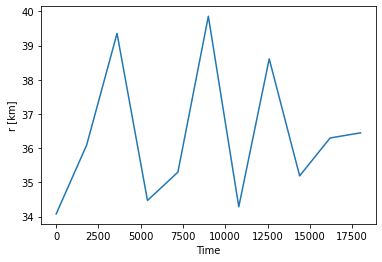

In [11]:
#%% Estimate temporal evolution of radial distance for each time series location at one height
radial_dist = np.zeros([len(time_center),np.shape(locs)[0]])
iz = 0

for it in np.arange(len(time_center)):
    radial_dist[it,:] = ((n_x[locs[:,0]] - center_x[it,iz])**2 + (n_y[locs[:,1]] - center_y[it,iz])**2)**0.5

# Time series of radial distance for a given met-tower at one height
mpyplot.figure()
mpyplot.plot(time_center_sinceRst,radial_dist[:,-1]/1000)
mpyplot.xlabel('Time')
mpyplot.ylabel('r [km]')

Text(0, 0.5, 'r [km]')

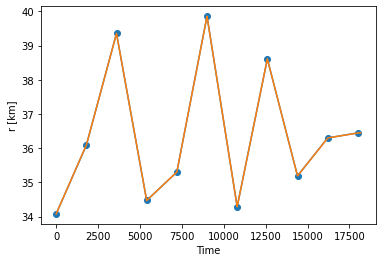

In [12]:
#%% Interpolate data in time to match time series output
# Interpolate center of hurricane at each height
center = np.zeros([len(time_sinceRst),np.shape(center_x)[1],2]) # [time, height, x or y center location]
for i_z in np.arange(np.shape(center_x)[1]):
    center[:,i_z,0] = np.interp(time_sinceRst,time_center_sinceRst,center_x[:,i_z])
    center[:,i_z,1] = np.interp(time_sinceRst,time_center_sinceRst,center_y[:,i_z])
    
# Interpolate radial distance from center of hurricane at z=10m
r_fromC = np.zeros([len(time_sinceRst),np.shape(locs)[0]]) # [time, station, radial distance]
for i_s in np.arange(np.shape(locs)[0]):
    r_fromC[:,i_s] = np.interp(time_sinceRst,time_center_sinceRst,radial_dist[:,i_s])
    
# Time series of radial distance for a given met-tower at one height
mpyplot.figure()
mpyplot.plot(time_center_sinceRst,radial_dist[:,-1]/1000,'-o')
mpyplot.plot(time_sinceRst,r_fromC[:,-1]/1000)
mpyplot.xlabel('Time')
mpyplot.ylabel('r [km]')

In [14]:
#%% Define moving average function
def moving_average(x, n,mode):
    mv_avg = np.zeros(np.shape(x))
    temp = np.convolve(x, np.ones(n), mode) / n #full valid same
    if mode=='valid':
        mv_avg[0:np.shape(x)[0]-n+1] = temp
        # Fill edges with data
        mv_avg[-n:] = np.sum(x[-n:])/n
    elif mode=='same':
        mv_avg = temp
        mv_avg[0:n] = np.sum(x[0:n])/n
        mv_avg[-n:] = np.sum(x[-n:])/n
    
    return mv_avg

#%% Define moving median function
from scipy.ndimage import median_filter
def moving_median(x, n):
    return median_filter(x[x != 0], n)


In [15]:
#%% Mean time step in simulations
dt = np.mean(time[1:] - time[0:-1])


Text(0, 0.5, 'Maximum instantaneous U [m/s]')

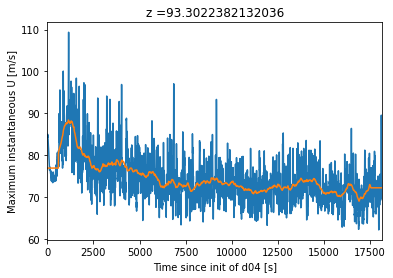

In [35]:
#%% Time series of maximum instantaneous wind speed at a given vertical level
col = mpyplot.cm.viridis(np.linspace(0,1,len(locs)))
iz = np.argmin(np.abs(hgt_agl - z_hh))+1

window_maxWS = 10*60 # [s]
nnn = int(window_maxWS/dt)

mpyplot.figure()
mpyplot.title('z ='+str(hgt_agl_stg[iz]))
mpyplot.plot(time_sinceRst,np.max(np.abs(UV[:,:,iz]),axis=0))
mpyplot.plot(time_sinceRst,moving_average(np.max(np.abs(UV[:,:,iz]),axis=0),nnn,'same'))
mpyplot.xlim(time_sinceRst[0],time_sinceRst[-1])
mpyplot.xlabel('Time since init of ' + str(domain)+' [s]')
mpyplot.ylabel('Maximum instantaneous U [m/s]')

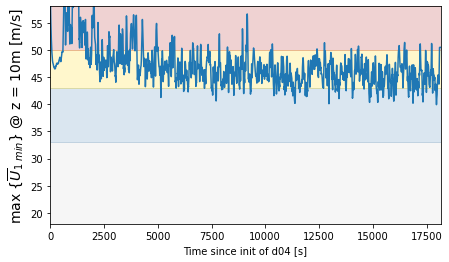

In [16]:
#%% Find hurricane category based on 1-min moving average at 10 m
# Time window
window_cat = 1*60 # [s]
n_window_cat = int(window_cat/dt)

# Height
zz_cat = 10
# i_zzz = np.argmin(np.abs(hgt_agl_stg - zzz))
i_zzz = np.argmin(np.abs(hgt_agl - zz_cat))

# Interpolate horizontal wind speed to desired height
uv_zzz = UV[:,:,i_zzz] + (UV[:,:,i_zzz+1] - UV[:,:,i_zzz])*(zz_cat - hgt_agl_stg[i_zzz])/(hgt_agl_stg[i_zzz+1] - hgt_agl_stg[i_zzz])

# Estimate moving average 
avgUV_cat = np.zeros(np.shape(uv_zzz))

for i_s in np.arange(np.shape(uv_zzz)[0]):
    avgUV_cat[i_s,:] = moving_average(uv_zzz[i_s,:],n_window_cat,'valid')
    
# Figure of max 1-min winds from all stations
mpyplot.figure(figsize=(7,4))
mpyplot.plot(time_sinceRst,np.max(avgUV_cat,axis=0))
mpyplot.fill([time_sinceRst[0],time_sinceRst[-1],time_sinceRst[-1],time_sinceRst[0]],[18,18,32.999,32.999],alpha=0.2,color='lightgrey')
mpyplot.fill([time_sinceRst[0],time_sinceRst[-1],time_sinceRst[-1],time_sinceRst[0]],[33,33,42.999,42.999],alpha=0.2,color='steelblue')
mpyplot.fill([time_sinceRst[0],time_sinceRst[-1],time_sinceRst[-1],time_sinceRst[0]],[43,43,49.999,49.999],alpha=0.2,color='gold')
mpyplot.fill([time_sinceRst[0],time_sinceRst[-1],time_sinceRst[-1],time_sinceRst[0]],[50,50,58,58],alpha=0.2,color='firebrick')
mpyplot.ylim([18,58])
mpyplot.xlim(time_sinceRst[0],time_sinceRst[-1])
mpyplot.xlabel('Time since init of ' + str(domain)+' [s]')
mpyplot.ylabel(r'max {$\overline{U}_{1\ min}$} @ z = 10m [m/s]',fontsize=14)
if saveFig=='True':
    mpyplot.savefig(WRF_DIRECTORY + "max_1min_ws.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')


In [17]:
#%% Save maximum 1-min sustained wind speed in domain


if saveCat == 'True':
    mmaaxxx = np.max(avgUV_cat,axis=0)
    fName = 'oneMinWs_woInterp.txt'
    if interp_to10=='True':
        fName = 'oneMinWs_withInterp.txt'
    with open(WRF_DIRECTORY + fName, 'w') as f:
        for i in np.arange(len(time_sinceRst)):
            strr = str(time_sinceRst[i]) + ',' + str(mmaaxxx[i])
            f.write(strr)
            f.write('\n')
    
    stop

In [18]:
#%% Time window for mean statistics
window_t = 10*60 # [s]
n_window = int(window_t/dt)

In [19]:
#%% Estimate moving average for each time series location and each height
avgU = np.zeros(np.shape(U))
avgV = np.zeros(np.shape(V))
avgW = np.zeros(np.shape(W))
avgUV = np.zeros(np.shape(UV))

for i_s in np.arange(np.shape(U)[0]): # station
    for iz in np.arange(np.shape(U)[2]): # height
        avgU[i_s,:,iz] = moving_average(U[i_s,:,iz],n_window,'same') # valid
        avgV[i_s,:,iz] = moving_average(V[i_s,:,iz],n_window,'same')
        avgW[i_s,:,iz] = moving_average(W[i_s,:,iz],n_window,'same')
        avgUV[i_s,:,iz] = moving_average(UV[i_s,:,iz],n_window,'same')

print('Done estimating mean flow conditions')

Done estimating mean flow conditions


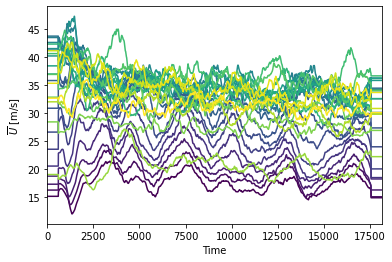

In [20]:
#%% Time series of average horizontal wind speed
# Height for plot
iz = 0

# Colors for plot
col = mpyplot.cm.viridis(np.linspace(0,1,np.shape(avgUV)[0]))

mpyplot.figure()
for i_s in np.arange(np.shape(avgUV)[0]):
    mpyplot.plot(time_sinceRst,avgUV[i_s,:,iz],color=col[i_s])
mpyplot.ylabel(r'$\overline{U}$ [m/s]')
mpyplot.xlabel('Time')
mpyplot.xlim(time_sinceRst[0],time_sinceRst[-1])
mpyplot.show()

In [21]:
#%% Estimate perturbation quantities
pertU = U - avgU
pertV = V - avgV
pertW = W - avgW
pertUV = UV - avgUV

# Detrend perturbations
pertU = scipy.signal.detrend(pertU,axis=1)
pertV = scipy.signal.detrend(pertV,axis=1)
pertW = scipy.signal.detrend(pertW,axis=1)
pertUV = scipy.signal.detrend(pertUV,axis=1)

print('Done estimating perturbation quantities')

Done estimating perturbation quantities


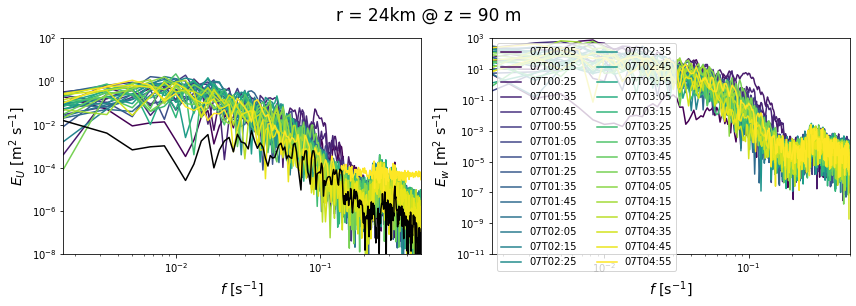

In [29]:
# #%% Get turbulence spectra for each window length at ONE height
# Time window
window_spct = 10*60 # [s]
n_window_spct = int(window_spct/dt)


zz_spctra = z_hh #10
iz = np.argmin(np.abs(hgt_agl - zz_spctra))
# freqs,temp_P = signal.periodogram(pertUV[0,0:n_window_spct,iz], fs=1/dt,window='hanning',scaling='density')
freqs,temp_P = signal.welch(pertUV[0,0:n_window_spct,iz], fs=1/dt,window='hanning',nperseg=n_window_spct,scaling='density')

P_ww = np.zeros([np.shape(U)[0],int(np.shape(U)[1]/n_window_spct),len(freqs)])
P_uv = np.zeros([np.shape(U)[0],int(np.shape(U)[1]/n_window_spct),len(freqs)])
mean_U_hh = np.zeros([np.shape(U)[0],int(np.shape(U)[1]/n_window_spct)])
var_U_hh = np.zeros([np.shape(U)[0],int(np.shape(U)[1]/n_window_spct)])
time_spectra = np.zeros(int(np.shape(U)[1]/n_window_spct))

for i_s in np.arange(np.shape(U)[0]):
    c = 0
    for it in np.arange(0,len(time)-n_window_spct,n_window_spct):
        # Horizontal velocity
#         f,P = signal.periodogram(pertUV[i_s,it:it+n_window_spct,iz], fs=1/dt,window='hanning',scaling='density')
        f,P = signal.welch(pertUV[i_s,it:it+n_window_spct,iz], fs=1/dt,window='hanning',nperseg=n_window_spct,scaling='density')
        P_uv[i_s,c,:] = P
        
        # Vertical velocity
#         f,P = signal.periodogram(pertW[i_s,it:it+n_window_spct,iz], fs=1/dt,window='hanning',scaling='density')
        f,P = signal.welch(pertW[i_s,it:it+n_window_spct,iz], fs=1/dt,window='hanning',nperseg=n_window_spct,scaling='density')
        P_ww[i_s,c,:] = P
        
        # Mean and std
        mean_U_hh[i_s,c] = np.mean(avgUV[i_s,it:it+n_window_spct,iz])
        var_U_hh[i_s,c] = np.mean(pertUV[i_s,it:it+n_window_spct,iz]*pertUV[i_s,it:it+n_window_spct,iz])
        
        # Save time
        if i_s==0:
            time_spectra[c] = np.mean(time[it:it+n_window_spct])
        
        # Counter
        c = c + 1

# Time in datetime
TIME_s = startTime + time_spectra.astype('timedelta64[s]')








#%% Evaluate temporal evolution of spectra at one height and one radial location
# Choose station to evaluate spin up
stat = np.argmin(np.abs(radial_dist[iz,:] - 25000))

# Colors for plot
col = mpyplot.cm.viridis(np.linspace(0,1,np.shape(P_uv)[1]))

# Figure for all time period
mpyplot.figure(figsize=(12,4))
mpyplot.suptitle('r = ' + str(int(radial_dist[iz,stat]/1000)) + "km @ z = "+str(int(zz_spctra)) + ' m',y=1.05,fontsize=17)
# Horizontal velocity
mpyplot.subplot(1,2,1)
for it in np.arange(0,np.shape(P_uv)[1],1):
    mpyplot.loglog(freqs,freqs*P_uv[stat,it,:]/var_U_hh[stat,it],color=col[it])
mpyplot.loglog(freqs,freqs*P_uv[stat,0,:]/var_U_hh[stat,it],color='k')
mpyplot.xlim(freqs[1],freqs[-1])
mpyplot.ylim(1e-8,np.max([5e4,np.max(P_uv[stat,it,:])]))
mpyplot.ylim(1e-8,1e2)
mpyplot.ylabel(r'$E_{U}$ [m$^2$ s$^{-1}$]',fontsize=14)
mpyplot.xlabel(r'$f$ [s$^{-1}$]',fontsize=14)

# Vertical velocity
mpyplot.subplot(1,2,2)
for it in np.arange(0,np.shape(P_ww)[1],1):
    mpyplot.loglog(freqs,P_ww[stat,it,:],color=col[it],label=str(TIME_s[it])[8:-3])
mpyplot.xlim(freqs[1],0.5)
mpyplot.ylim(1e-11,np.max([1e3,np.max(P_ww[stat,it,:])]))
mpyplot.ylabel(r'$E_{w}$ [m$^2$ s$^{-1}$]',fontsize=14)
mpyplot.xlabel(r'$f$ [s$^{-1}$]',fontsize=14)
mpyplot.legend(ncol=2)

mpyplot.tight_layout()
if saveFig=='True':
    mpyplot.savefig(WRF_DIRECTORY + "spectra_at_r.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')

mpyplot.show()
mpyplot.close()

stop


In [ ]:
#%% Get turbulence spectra using overlapping method at ONE height
# Time window
window_spct = 55*60 # [s]
n_window_spct = int(window_spct/dt)

zz_spctra = z_hh #10
iz = np.argmin(np.abs(hgt_agl - zz_spctra))
freqs,temp_P = signal.welch(pertUV[0,0:n_window_spct,iz], fs=1/dt,window='hanning',nperseg=n_window_spct,scaling='density')

P_ww = np.zeros([np.shape(U)[0],len(freqs)])
P_ww_norm = np.zeros([np.shape(U)[0],len(freqs)])
P_uv = np.zeros([np.shape(U)[0],len(freqs)])
P_uv_norm = np.zeros([np.shape(U)[0],len(freqs)])
mean_U_hh = np.zeros([np.shape(U)[0]])
var_U_hh = np.zeros([np.shape(U)[0]])
mean_W_hh = np.zeros([np.shape(U)[0]])
var_W_hh = np.zeros([np.shape(U)[0]])

for i_s in np.arange(np.shape(U)[0]):
    # Horizontal velocity
    f,P = signal.welch(pertUV[i_s,:,iz], fs=1/dt,window='hanning',nperseg=n_window_spct,scaling='density')
    P_uv[i_s,:] = P
    P_uv_norm[i_s,:] = f*P/np.sum(P[0:-1]*(f[1:] - f[0:-1]))
    
    # Vertical velocity
    f,P = signal.welch(pertW[i_s,:,iz], fs=1/dt,window='hanning',nperseg=n_window_spct,scaling='density')
    P_ww[i_s,:] = P
    P_ww_norm[i_s,:] = f*P/np.sum(P[0:-1]*(f[1:] - f[0:-1]))
    
    # Mean and std
    mean_U_hh[i_s] = np.mean(UV[i_s,:,iz]) #np.mean(avgUV[i_s,:,iz])
    var_U_hh[i_s] = np.var(UV[i_s,:,iz]) #np.mean(pertUV[i_s,:,iz]*pertUV[i_s,:,iz])
    mean_W_hh[i_s] = np.mean(W[i_s,:,iz])#np.mean(avgW[i_s,:,iz])
    var_W_hh[i_s] = np.var(W[i_s,:,iz])#np.mean(pertW[i_s,:,iz]*pertW[i_s,:,iz])

    
    


In [ ]:
#%% Kaimal model for different radial locations
def Kaimal_f(fff,aaa,bbb,ccc):#(fff,aaa,bbb):#,ccc):
#     aaa = 4
#     ccc = cc
    SS = (aaa*var_hh*L_u/V_hh)/( (bbb + ccc*(fff*L_u/V_hh) )**(5/3) )
    return SS

# Constants
L_u = 340
a = 4
b = 1
cc = 6 #6

# Estimate Kaimal spectra for each 10-min time period
expx = np.arange(-4,1,0.1)
ffff = 10**expx
Su_f_kaimal = np.zeros([np.shape(U)[0],len(ffff)])

for i_s in np.arange(np.shape(U)[0]):
    V_hh = mean_U_hh[i_s]
    var_hh = var_U_hh[i_s]
    Su_f_kaimal[i_s,:] = ffff*Kaimal_f(ffff,a,b,cc)/var_hh
#     Su_f_kaimal[i_s,:] = ffff*Kaimal_f(ffff,b)/var_hh


In [ ]:
#%% Karman model for different radial locations
def Karman_f(fff,aaa,bbb,ccc):
#     ccc = cc2
    SS = (aaa*var_hh*L_vk/V_hh)/( (bbb + ccc*((fff*L_vk/V_hh)**2) )**(5/6) )
    return SS

# Constants
L_vk = 340
a = 4
b = 1
cc2 = 71

# Estimate Kaimal spectra for each 10-min time period
Su_f_karman = np.zeros([np.shape(U)[0],len(ffff)])

for i_s in np.arange(np.shape(U)[0]):
    V_hh = mean_U_hh[i_s]
    var_hh = var_U_hh[i_s]
#     Su_f_karman[i_s,:] = ffff*Karman_f(ffff,a,b,c)/var_hh
    Su_f_karman[i_s,:] = ffff*Karman_f(ffff,a,b,cc2)/var_hh

In [ ]:
#%% Compare spectra between simulations and model (one met-mast)
# Choose station to evaluate spin up
stat = np.argmin(np.abs(radial_dist[iz,:] - r_eye))

# Figure for all time period
mpyplot.figure(figsize=(10,5))
mpyplot.suptitle('r = ' + str(int(radial_dist[iz,stat]/1000)) + "km @ z = "+str(int(zz_spctra)) + ' m',y=1.05,fontsize=17)
# Horizontal velocity
mpyplot.subplot(1,2,1)
mpyplot.loglog(freqs*zz_spctra/mean_U_hh[stat],freqs*P_uv[stat,:]/var_U_hh[i_s])
mpyplot.loglog(freqs*zz_spctra/mean_U_hh[stat],P_uv_norm[stat,:])
mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],Su_f_kaimal[stat,:],'--',color='black')
mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],Su_f_karman[stat,:],'--',color='darkgrey')
mpyplot.xlim(ffff[1]*zz_spctra/mean_U_hh[stat],ffff[-1]*zz_spctra/mean_U_hh[stat])
mpyplot.ylim(1e-3,np.max([1e0,np.max(P_uv_norm[stat,:])]))
# mpyplot.ylim(1e-2,1e1)
mpyplot.ylabel(r'$f\,E_{U}\,/\sigma^2$ [-]',fontsize=14)
mpyplot.xlabel(r'$f$ [s$^{-1}$]',fontsize=14)

# Vertical velocity
mpyplot.subplot(1,2,2)
mpyplot.loglog(freqs*zz_spctra/mean_U_hh[stat],P_ww_norm[stat,:])
mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],Su_f_kaimal[stat,:],'--',color='black')
mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],Su_f_karman[stat,:],'--',color='darkgrey')
mpyplot.xlim(ffff[1]*zz_spctra/mean_U_hh[stat],ffff[-1]*zz_spctra/mean_U_hh[stat])
mpyplot.ylim(1e-3,np.max([1e0,np.max(P_ww_norm[stat,:])]))
# mpyplot.ylim(1e-2,1e1)
mpyplot.ylabel(r'$f\,E_{w}\,/\sigma^2$ [-]',fontsize=14)
mpyplot.xlabel(r'$f$ [s$^{-1}$]',fontsize=14)

mpyplot.tight_layout()
if saveFig=='True':
    mpyplot.savefig(WRF_DIRECTORY + "spectra_at_r.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')

mpyplot.show()
mpyplot.close()

In [ ]:
#%% Met-towers in center of 9x9 array
i_cent = np.arange(4,len(locs[:,0]),9)
print(i_cent)
stat = np.argmin(np.abs(radial_dist[iz,i_cent[:]] - r_eye))
print(radial_dist[iz,i_cent[stat]])


In [ ]:
#%% Compare spectra between simulations and model (9x9 array at radial location)
# Choose station to evaluate spin up
stat = np.argmin(np.abs(radial_dist[iz,i_cent[:]] - r_eye))

# Average spectra for surrounding stations to center met mast
# mean_norm_P_uv = 10**np.mean(np.log10(P_uv_norm[stat-4:stat+5,:]),axis=0)
statss = np.arange(i_cent[stat]-4-0,i_cent[stat]+5+9)
mean_norm_P_uv = np.mean(P_uv_norm[statss,:],axis=0)
mean_norm_P_ww = np.mean(P_ww_norm[statss,:],axis=0)

# Maximum resolvable frequency by model
f_max_model = (np.mean(mean_U_hh[statss])/(7*dx))*zz_spctra/np.mean(mean_U_hh[statss]) #(0.5/np.pi)*
f_min_model = (1/window_spct)*zz_spctra/mean_U_hh[stat]

# Fit spectra from simulations to Kaimal and Karman model
from scipy.optimize import curve_fit
V_hh = mean_U_hh[i_cent[stat]]
var_hh = var_U_hh[i_cent[stat]]
max_f = f_max_model # 9e-1 #1e-1
min_f = f_min_model #0 #1e-3
i_maxF = np.argmin(np.abs(freqs*zz_spctra/mean_U_hh[stat] - max_f))
i_minF = np.argmin(np.abs(freqs*zz_spctra/mean_U_hh[stat] - min_f))
# popt_kaimal, pcov_kaimal = curve_fit(Kaimal_f, freqs[i_minF:i_maxF], np.mean(P_uv[statss,i_minF:i_maxF],axis=0), maxfev=5000)
popt_kaimal, pcov_kaimal = curve_fit(Kaimal_f, freqs[i_minF:i_maxF], var_hh*mean_norm_P_uv[i_minF:i_maxF]/freqs[i_minF:i_maxF], maxfev=5000)
popt_karman, pcov_karman = curve_fit(Karman_f, freqs[i_minF:i_maxF], np.mean(P_uv[statss,i_minF:i_maxF],axis=0), maxfev=5000)
fit_norm_P_uv_kaimal = ffff*Kaimal_f(ffff, *popt_kaimal)/var_hh
fit_norm_P_uv_karman = ffff*Karman_f(ffff, *popt_karman)/var_hh

# Figure for all time period
mpyplot.figure(figsize=(5,5)) #figsize=(10,5)
mpyplot.title('r = ' + str(int(np.mean(radial_dist[iz,statss]/1000))) + "km @ z = "+str(int(zz_spctra)) + ' m',y=1.05,fontsize=17)
# Horizontal velocity
# mpyplot.subplot(1,2,1)
mpyplot.loglog(freqs[:]*zz_spctra/mean_U_hh[stat],mean_norm_P_uv[:]/np.sum(P_uv_norm[i_cent[stat],1:]*(freqs[1:] - freqs[0:-1])/freqs[1:]))
mpyplot.loglog(freqs[i_minF:i_maxF]*zz_spctra/mean_U_hh[stat],mean_norm_P_uv[i_minF:i_maxF])
# mpyplot.loglog(freqs[i_minF:i_maxF]*zz_spctra/mean_U_hh[stat],freqs[i_minF:i_maxF]*np.mean(P_uv[statss,i_minF:i_maxF],axis=0)/var_hh)
mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],fit_norm_P_uv_kaimal,':k')
mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],fit_norm_P_uv_kaimal/np.sum(fit_norm_P_uv_kaimal[1:]*(ffff[1:] - ffff[0:-1])/ffff[1:]),'-k',label='Fit-Kaimal')
mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],fit_norm_P_uv_karman,':',color='darkgrey')
mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],fit_norm_P_uv_karman/np.sum(fit_norm_P_uv_karman[1:]*(ffff[1:] - ffff[0:-1])/ffff[1:]),'-',color='darkgrey',label='Fit-Karman')
mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],Su_f_kaimal[i_cent[stat],:],'--',color='black',label='IEC Kaimal')
mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],Su_f_karman[i_cent[stat],:],'--',color='darkgrey',label='IEC Karman')
mpyplot.xlim(ffff[1]*zz_spctra/mean_U_hh[stat],ffff[-1]*zz_spctra/mean_U_hh[stat])
mpyplot.loglog([f_max_model,f_max_model],[3e-3,np.max([1e0,np.max(mean_norm_P_uv)])],'-k',linewidth=0.5)
mpyplot.ylim(3e-3,np.max([1e0,np.max(mean_norm_P_uv)]))
# mpyplot.ylim(1e-2,1e1)
mpyplot.ylabel(r'$f\,E_{U}\,/\sigma^2$ [-]',fontsize=14)
mpyplot.xlabel(r'$f\, z/\overline{U}$ [-]',fontsize=14)
mpyplot.legend()

# Vertical velocity
# mpyplot.subplot(1,2,2)
# mpyplot.loglog(freqs*zz_spctra/mean_U_hh[stat],mean_norm_P_ww)
# mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],Su_f_kaimal[stat,:],'--',color='black')
# mpyplot.loglog(ffff*zz_spctra/mean_U_hh[stat],Su_f_karman[stat,:],'--',color='darkgrey')
# mpyplot.xlim(ffff[1]*zz_spctra/mean_U_hh[stat],ffff[-1]*zz_spctra/mean_U_hh[stat])
# mpyplot.ylim(1e-3,np.max([1e0,np.max(mean_norm_P_ww)]))
# # mpyplot.ylim(1e-2,1e1)
# mpyplot.ylabel(r'$f\,E_{w}\,/\sigma^2$ [-]',fontsize=14)
# mpyplot.xlabel(r'$f\, z/\overline{U}$ [-]',fontsize=14)

mpyplot.tight_layout()
if saveFig=='True':
    mpyplot.savefig(WRF_DIRECTORY + "spectra_at_r.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')

mpyplot.show()
mpyplot.close()


print('The fit to the Kaimal and Karman models completely underestiamte the energy at higher frequencies,' +
      '\nlikely due to our simulations have too "coarse" resolution and not capturing the smaller scales of turbulence.' +
      '\nAs a result, the model is biased towards more energy at low frequencies and the coefficients for the curve fit \nare not accurate.')

In [ ]:
print(np.sum(fit_norm_P_uv_kaimal[1:]*(ffff[1:] - ffff[0:-1])/ffff[1:]))
print(np.sum(fit_norm_P_uv_karman[1:]*(ffff[1:] - ffff[0:-1])/ffff[1:]))
print(np.sum(P_uv_norm[i_cent[stat],1:]*(freqs[1:] - freqs[0:-1])/freqs[1:]))
print(np.sum(P_uv[i_cent[stat],1:]*(freqs[1:] - freqs[0:-1]))/var_hh)

print(np.sum(Su_f_kaimal[stat,1:]*(ffff[1:] - ffff[0:-1])/ffff[1:]))
print(np.sum(Su_f_karman[stat,1:]*(ffff[1:] - ffff[0:-1])/ffff[1:]))


In [ ]:
#%% Define functions that estimate change in wind direction

# Define function that estimates temporal change in wind direction for one height
def delta_wDir_oneZ(wDir1,wDir2):
    delta = np.abs(wDir1 - wDir2)
    
    if delta>180:
        delta = 360 - delta
        
    return delta



# Define function that estimates vertical change in wind direction for one time
def delta_wDir_twoZ(wDir1,wDir2,z1,z2,normalize):
    wDir_low = wDir1
    wDir_high = wDir2
    
    delta = 0
    
    if np.abs(wDir_high-wDir_low)<=0:#180:
        delta = wDir_high-wDir_low
    else:
        a = np.abs(wDir_high-wDir_low)
        b = np.abs(360-a)
        delta = np.min([a,b])
        
        if (wDir_high>=0) & (wDir_high<=90):
            if (wDir_low>=270) & (wDir_low<=360):
                delta = 1*delta
        elif (wDir_high>=270) & (wDir_high<=360):
            if (wDir_low>=0) & (wDir_low<=90):
                delta = -1*delta
    
    dz = z2-z1
    if dz>0:
        if normalize=='True':
            delta = delta/dz
        
    return delta



In [ ]:
#%% Calculate yaw misalignment for one height
t_yaw_mis = 10 # [s]
n_window_yaw_mis = int(t_yaw_mis/dt) # [number of time steps]

# Height of interest
zzz = z_hh
i_zzz = np.argmin(np.abs(hgt_agl - zzz))

# Moving average wind direction for time window
wDir_avg_yaw_mis = np.zeros(np.shape(wDir)[0:2])
for i_s in np.arange(np.shape(locs)[0]):
    wDir_avg_yaw_mis[i_s,:] = wDir[i_s,:,i_zzz] #moving_average(wDir[i_s,:,i_zzz],n_window_yaw_mis,'valid')

# Temporal change in wind direction over time window    
# yaw_mis = np.zeros(np.shape(wDir_avg_yaw_mis))
# for i_s in np.arange(np.shape(locs)[0]):
#     for i_t in np.arange(np.shape(wDir)[1]-n_window_yaw_mis):
#         tempMax = 0
#         for ii in np.arange(n_window_yaw_mis):
#             dd = np.abs(delta_wDir_oneZ(wDir_avg_yaw_mis[i_s,i_t],wDir_avg_yaw_mis[i_s,i_t+ii]))
#             if dd>tempMax:
#                 tempMax = dd
#         yaw_mis[i_s,i_t] = tempMax
#     print('Done with station ' + str(i_s) + ' of ' + str(np.shape(locs)[0]-1))

# Temporal change in wind direction over time window    
yaw_mis = np.zeros(np.shape(wDir_avg_yaw_mis)) + np.nan
for i_s in np.arange(np.shape(locs)[0]):
    for i_t in np.arange(np.shape(wDir)[1]-n_window_yaw_mis):
        tempMax = 0
        mxx = np.max(wDir_avg_yaw_mis[i_s,i_t:i_t+n_window_yaw_mis])
        mnn = np.min(wDir_avg_yaw_mis[i_s,i_t:i_t+n_window_yaw_mis])
        tempMax = delta_wDir_oneZ(mxx,mnn)
        yaw_mis[i_s,i_t] = tempMax
    print('Done with station ' + str(i_s) + ' of ' + str(np.shape(locs)[0]-1))

print('Yaw misalignment is calculated using instantaneous wind speeds? or time-averaged wind speeds?')


# Flatten arrays
r_flat = r_fromC.flatten()
yaw_mis_flat  = np.transpose(yaw_mis).flatten()
# Sort arrays
i_sort = np.argsort(r_flat)
r_sort = r_flat[i_sort]
yaw_mis_sort_r = yaw_mis_flat[i_sort]

# Distribution of max yaw misalignment at multiple radial locations
r_incr = np.arange(np.min(r_fromC),np.max(r_fromC),1000) # Radial locations to estimate yaw misalignment
yaw_incr = np.arange(0,40,0.5)
distr_yawMis_r = np.zeros([len(r_incr)-1,len(yaw_incr)-1])
for ir in np.arange(len(r_incr)-1):
    temp_arr = yaw_mis_sort_r[(r_sort>r_incr[ir]) & ((r_sort<=r_incr[ir+1]))]
    distr_yawMis_r[ir,:] = np.histogram(temp_arr[temp_arr>0],bins=yaw_incr)[0]
bins_plot = 0.5*(yaw_incr[1:] + yaw_incr[0:-1])

# Figure of yaw misalignment at multiple radial location
col = mpyplot.cm.viridis(np.linspace(0,1,len(r_incr)-1))
mpyplot.figure()
for ir in np.arange(len(r_incr)-1):
    rrr = 0.5*(r_incr[ir]+r_incr[ir+1])
    mpyplot.plot(bins_plot,distr_yawMis_r[ir,:]/np.sum(distr_yawMis_r[ir,:]),label='r = '+str(int(rrr/1000))+'km',color=col[ir])
mpyplot.xlim(0,20)
mpyplot.ylim(0,0.25)
mpyplot.legend(ncol=3)
mpyplot.xlabel(r'$\Delta \phi$ [deg]')
mpyplot.ylabel('Probability density [-]')
if saveFig=='True':
    mpyplot.savefig(WRF_DIRECTORY + "yaw_mis.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()

# Time series of wind direction and yaw misalignment
mpyplot.figure(figsize=(10,3))
# Yaw misalignment
mpyplot.subplot(1,2,1)
for ii in np.arange(np.shape(locs)[0]):
    mpyplot.plot(time_sinceRst,yaw_mis[ii,:]); 
mpyplot.xlim(2200,2300)
# mpyplot.plot(time_sinceRst,yaw_mis[15,:],'k'); 
mpyplot.ylabel('Yaw misalignment [deg]')
mpyplot.xlabel('Time [s]')
# Wind direction
mpyplot.subplot(1,2,2)
for ii in np.arange(np.shape(locs)[0]):
    mpyplot.plot(time_sinceRst,wDir[ii,:,i_zzz]); 
# mpyplot.plot(time_sinceRst,wDir[15,:,i_zzz],'k'); 
mpyplot.xlim(2200,2300)
mpyplot.ylabel('Wind direction [deg]')
mpyplot.xlabel('Time [s]')
mpyplot.tight_layout()
mpyplot.show()

In [ ]:
#%% Calculate direction shear across turbine rotor layer
t_veer = 10 # [s]
n_window_veer = int(t_veer/dt) # [number of time steps]


# Whether or not to normalize veer
normalize = 'True'
print('normalize == ' + normalize)

# Reference height
zzz = z_hh
i_zzz = np.argmin(np.abs(hgt_agl - zzz))

# Moving average wind direction for time window
wDir_ref = np.zeros(np.shape(wDir)[0:2])
for i_s in np.arange(np.shape(locs)[0]):
    tempp = moving_median(wDir[i_s,:,i_zzz],n_window_veer)
    wDir_ref[i_s,0:len(tempp)] = tempp
    
# Estimate veer using moving average wind direction with respect to reference height
veer = np.zeros_like(wDir)
for i_s in np.arange(np.shape(locs)[0]):
    for iz in np.arange(len(hgt_agl)):
        temp_wDir = moving_median(wDir[i_s,:,i_z],n_window_veer)
        for i_t in np.arange(len(time_sinceRst)):
            if iz<i_zzz:
                veer[i_s,i_t,iz] = delta_wDir_twoZ(temp_wDir[i_t],wDir_ref[i_s,i_t],hgt_agl[iz],hgt_agl[i_zzz],normalize)
            else:
                veer[i_s,i_t,iz] = delta_wDir_twoZ(wDir_ref[i_s,i_t],temp_wDir[i_t],hgt_agl[i_zzz],hgt_agl[iz],normalize)
    print('Done with station ' + str(i_s) + ' of ' + str(np.shape(locs)[0]-1))
    
## Get radial distribution of maximum veer at each height 
# Flat radial location array
r_flat = r_fromC.flatten()
# Sort arrays
i_sort = np.argsort(r_flat)
r_sort = r_flat[i_sort]
# Radial increments of interest
r_incr = np.arange(np.min(r_fromC),np.max(r_fromC),1000)
# Initalize array
max_veer = np.zeros([len(r_incr)-1,len(hgt_agl)])
for iz in np.arange(len(hgt_agl)):
    if iz==i_zzz:
        print('Do nothing')
    else:
        # Flatten array
        flat_veer = np.transpose(veer[:,:,iz]).flatten()
        # Sort flat array
        flat_veer = flat_veer[i_sort]
        # Find maximum veer at each radial location
        for i_r in np.arange(len(r_incr)-1):
            temp_arr = flat_veer[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
#             if normalize=='True':
#                 temp_arr[temp_arr>10] = np.nan
#             else:
#                 temp_arr[temp_arr>100] = np.nan
            max_veer[i_r,iz] = np.nanmax(np.abs(temp_arr))
    
r_incr = 0.5*(r_incr[1:] + r_incr[0:-1])

# Figure showing radial distribution of maximum veer at each height
mpyplot.figure()
# mpyplot.contourf(r_incr,hgt_agl,np.transpose(max_veer),levels=12)
mpyplot.pcolormesh(r_incr,hgt_agl,np.transpose(max_veer))
# mpyplot.ylim(hgt_agl[0],200)
cbar = mpyplot.colorbar()
if normalize=='True':
    cbar.set_label('Max direction shear [deg/m]')
else:
    cbar.set_label('Max direction shear [deg]')
if saveFig=='True':
    mpyplot.savefig(WRF_DIRECTORY + "dirShear_BL.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()

In [ ]:
#%% Get maximum change in wind direction over turbine rotor layer
# Heights covering turbine rotor layer
z_bott = z_hh - 0.5*D
z_top = z_hh + 0.5*D
iz_b = np.argmin(np.abs(hgt_agl - z_bott))
iz_t = np.argmin(np.abs(hgt_agl - z_top))

print('Turbine rotor layer is between %f and %f ' % (hgt_agl[iz_b],hgt_agl[iz_t]))

# Estimate veer over turbine rotor layer
veer_RL = np.zeros(np.shape(wDir)[0:2])
for i_s in np.arange(np.shape(locs)[0]):
    # Time-averaged wind direction at each height
    wDir_bott =  moving_median(wDir[i_s,:,iz_b],n_window_veer)
    wDir_top =  moving_median(wDir[i_s,:,iz_t],n_window_veer)
    for i_t in np.arange(len(time_sinceRst)):
        veer_RL[i_s,i_t] = delta_wDir_twoZ(wDir_bott[i_t],wDir_top[i_t],hgt_agl[iz_b],hgt_agl[iz_t],normalize)
    print('Done with station ' + str(i_s) + ' of ' + str(np.shape(locs)[0]-1))

## Get radial distribution of wind veer over turbine rotor layer
# Flatten arrays
r_flat = r_fromC.flatten()
veer_RL_flat  = np.transpose(veer_RL).flatten()
# Sort arrays
i_sort = np.argsort(r_flat)
r_sort = r_flat[i_sort]
veer_RL_flat = veer_RL_flat[i_sort]
# Average veer, ith percentile and maximum veer for each radial location
i_th = 0.95
r_incr = np.arange(np.min(r_fromC),np.max(r_fromC),1000)
mean_veer_RL_r = np.zeros(len(r_incr)-1)
max_veer_RL_r = np.zeros(len(r_incr)-1)
ith_perc_veer_RL_r = np.zeros(len(r_incr)-1)
for i_r in np.arange(len(r_incr)-1):
    temp_arr = veer_RL_flat[(r_sort>r_incr[i_r]) & ((r_sort<=r_incr[i_r+1]))]
    temp_arr = np.abs(temp_arr)
    mean_veer_RL_r[i_r] = np.median(temp_arr)
    ith_perc_veer_RL_r[i_r] = np.percentile(temp_arr,i_th*100)
    max_veer_RL_r[i_r] = np.max(temp_arr)
    
r_incr = 0.5*(r_incr[1:] + r_incr[0:-1])

mpyplot.figure()
mpyplot.plot(r_sort[::50]/1000,np.abs(veer_RL_flat[::50]),label=str(t_veer)+'-sec')
mpyplot.plot(r_incr/1000,mean_veer_RL_r,label='Median')
mpyplot.plot(r_incr/1000,ith_perc_veer_RL_r,label=str(int(i_th*100))+'th percentile')
mpyplot.plot(r_incr/1000,max_veer_RL_r,label='Max')
mpyplot.xlabel('r [km]')
if normalize=='True':
    mpyplot.ylabel(r'$\Delta \phi$ rotor layer [deg/m]')
else:
    mpyplot.ylabel(r'$\Delta \phi$ rotor layer [deg]')
mpyplot.xlim(np.min(r_incr/1000),np.max(r_incr/1000))
mpyplot.legend()
if saveFig=='True':
    mpyplot.savefig(WRF_DIRECTORY + "dirShear_RL.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')
mpyplot.show()    

# Time series of wid direction at two heights
mpyplot.figure()
mpyplot.plot(time_sinceRst,wDir_bott)
mpyplot.plot(time_sinceRst,wDir_top)

In [ ]:
# Time series of wind direction at two heights
stattt = 6#26 # 19
mpyplot.figure()
mpyplot.plot(time_sinceRst,moving_median(wDir[stattt,:,iz_b],n_window_veer),label='bottom')
mpyplot.plot(time_sinceRst,moving_median(wDir[stattt,:,iz_t],n_window_veer),label='top')
mpyplot.xlim(time_sinceRst[0],time_sinceRst[-1])
mpyplot.legend()
mpyplot.ylabel(r'$\phi$ [deg]')
mpyplot.xlabel('Time')

mpyplot.figure()
mpyplot.plot(time_sinceRst[::10],moving_median(U[stattt,::10,iz_b],n_window_veer),'-b',label='u-bottom')
mpyplot.plot(time_sinceRst[::10],moving_median(U[stattt,::10,iz_t],n_window_veer),'-r',label='u-top')
mpyplot.plot(time_sinceRst[::10],moving_median(V[stattt,::10,iz_b],n_window_veer),'--b',label='v-bottom')
mpyplot.plot(time_sinceRst[::10],moving_median(V[stattt,::10,iz_t],n_window_veer),'--r',label='v-top')
mpyplot.xlim(time_sinceRst[0],time_sinceRst[-1])
mpyplot.legend()
mpyplot.ylabel(r'$U$ [m/s]')
mpyplot.xlabel('Time')

mpyplot.figure()
mpyplot.plot(time_sinceRst,veer_RL[stattt,:])

In [ ]:
#%% Wind speed profile at time and location of maximum 1-min wind speed
loc_max = 0
t_max = 0
maxxx = 0
for i_s in np.arange(np.shape(locs)[0]):
    tempMax = np.max(avgUV_cat[i_s,:])
    if tempMax>maxxx:
        loc_max = i_s
        t_max = np.argmax(avgUV_cat[i_s,:])
        maxxx = tempMax
    
# Figure: 10-min wind speed profile for max 1-min 10m winds
mpyplot.figure(figsize=(3.5,5))
mpyplot.plot(avgUV[loc_max,t_max,:],hgt_agl)
mpyplot.ylabel('Height [m]')
mpyplot.xlabel(r'$\overline{U}_{10\ min}$ [m/s]')
mpyplot.show()
        

In [ ]:
stat_indices = np.argmax(avgUV_cat,axis=0)
np.shape(avgUV_cat)

In [ ]:
#%% Correlation between max 1-min winds at z=10m and 10-min winds at z_hh

stat_indices = np.argmax(avgUV_cat,axis=0)
# Save 1-min surface winds and 10-min hub-height winds
winds_surf_hh = np.zeros([len(stat_indices),2]) # [surface, hh]
for ii in np.arange(len(stat_indices)):
    winds_surf_hh[ii,0] = avgUV_cat[stat_indices[ii],ii]
    winds_surf_hh[ii,1] = avgUV_mean[stat_indices[ii],ii]

bins = np.arange(np.min(winds_surf_hh),np.max(winds_surf_hh),1)
hist_2d,xEdg,yEdg = np.histogram2d(winds_surf_hh[:,0],winds_surf_hh[:,1],bins)

slope, intercept, r, p, se = scipy.stats.linregress(winds_surf_hh[:,0],winds_surf_hh[:,1])

mpyplot.figure()
mpyplot.scatter(winds_surf_hh[:,0],winds_surf_hh[:,1])
mpyplot.plot(xEdg,slope*xEdg +intercept,'--k')
mpyplot.xlabel('Max surface 1-min winds')
mpyplot.ylabel('Hub-height 10-min winds')
mpyplot.show()

mpyplot.figure()
im1 = mpyplot.pcolormesh(xEdg,yEdg,np.transpose(hist_2d)/np.sum(hist_2d),cmap=mpyplot.cm.binary)
mpyplot.plot(xEdg,slope*xEdg +intercept,'--k')
mpyplot.annotate(r'$U_{hh}$ = ' + str(np.round(slope,2)) + ' $U_{10}$ + '+str(np.round(intercept,2)),xy=(52,60))
mpyplot.annotate(r'$R^2$ = ' + str(np.round(r**2,2)),xy=(52,58))
mpyplot.xlabel('Max surface 1-min winds')
mpyplot.ylabel('Hub-height 10-min winds')
mpyplot.plot(bins,bins,'-k',linewidth=0.5)
mpyplot.colorbar(im1)
mpyplot.xlim(bins[0],bins[-1])
mpyplot.ylim(bins[0],bins[-1])
mpyplot.show()

In [ ]:
#%% Log-relationship between height and 10-min winds
def logFunc(z_,a,b):
    return a*(np.log(b*z_)+0)# + c*V_surf
from scipy.optimize import curve_fit

mod_params_z_meanU = np.zeros([len(stat_indices),3])
# Get function fit parameters 10-min wind speed profile at locations with maximum 1-min winds
for ii in np.arange(len(stat_indices)):
    V_surf = avgUV_cat[stat_indices[ii],ii]
    V_prof = avgUV[stat_indices[ii],ii,:]
    popt, pcov = curve_fit(logFunc, hgt_agl, V_prof)
    mod_params_z_meanU[ii,0] = popt[0]
    mod_params_z_meanU[ii,1] = popt[1]
#     mod_params_z_meanU[ii,2] = popt[2]
#     winds_surf_hh[ii,0] = avgUV_cat[stat_indices[ii],ii]
#     winds_surf_hh[ii,1] = avgUV_mean[stat_indices[ii],ii]

# Figure: 10-min wind speed profile for max 1-min 10m winds
mpyplot.figure(figsize=(3.5,5))
mpyplot.plot(avgUV[loc_max,t_max,:],hgt_agl)
mpyplot.plot(logFunc(hgt_agl, *np.mean(mod_params_z_meanU[:,0:2],axis=0)),hgt_agl)
mpyplot.ylabel('Height [m]')
mpyplot.xlabel(r'$\overline{U}_{10\ min}$ [m/s]')
mpyplot.show()

## Estimate 10-min hub-height wind speed based on 1-min winds at surface
izz = np.argmin(np.abs(hgt_agl - z_hh))
# Estimate 10-min wind speed at surface based on 1-min wind at surface
# Save 1-min surface winds and 10-min hub-height winds
winds_1surf_10surf = np.zeros([len(stat_indices),3]) # [1-min surface, 10-min surface, 10-min hub-height]
for ii in np.arange(len(stat_indices)):
    winds_1surf_10surf[ii,0] = avgUV_cat[stat_indices[ii],ii]
    winds_1surf_10surf[ii,1] = avgUV[stat_indices[ii],ii,0]
    winds_1surf_10surf[ii,2] = avgUV[stat_indices[ii],ii,izz]
slope, intercept, r, p, se = scipy.stats.linregress(winds_1surf_10surf[:,0],winds_1surf_10surf[:,1])
# Estimate 10-min hub-height wind speed based on estiamte of 10-min surface wind
est_profile = logFunc(hgt_agl, *np.median(mod_params_z_meanU[:,0:2],axis=0))
est_10min_hh = np.zeros(len(stat_indices))
for ii in np.arange(len(stat_indices)):
    # Estimate 10-min winds
    est10_surf = slope*avgUV_cat[stat_indices[ii],ii] +intercept
    # Estimate 10-min hub-height
    prof = est_profile + (est10_surf-est_profile[0])
    est_10min_hh[ii] = prof[izz]

# Compare estimate of 10-min winds and actual 10-min winds at locations with max 1-min winds
mpyplot.figure()
mpyplot.scatter(winds_1surf_10surf[:,2],est_10min_hh)
mpyplot.plot(winds_1surf_10surf[:,2],winds_1surf_10surf[:,2],'-k')
mpyplot.ylabel('Estimate of 10-min hh winds')
mpyplot.xlabel('Sim of 10-min hh winds')

np.corrcoef(est_10min_hh,winds_1surf_10surf[:,2])